# About

スタンプラリーの最短経路問題に挑戦する。

In [1]:
# !pip install japanize-matplotlib

In [2]:
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pandas as pd

import yaml

sns.set_theme()

# データを作る

以下の方針でデータを作成

- グラフで駅の隣接関係を定義する
    - ノードは駅
    - 隣接する駅にエッジを設定し、重みは運賃
- 距離行列では、隣接状態にない駅のコストは、該当駅間の最短経路の運賃の総和とする

In [3]:
# data_path = "../data/target_stations_small.yaml"
data_path = "../data/target_stations.yaml"

with open(data_path, 'r', encoding='utf-8') as file:
    fares = yaml.safe_load(file)

len(fares["fares"])

82

In [4]:
fares["fares"][0]

{'stations': ['春日部', '大宮'], 'fare': 324}

In [5]:
station_fares = [sorted(fare["stations"]) + [fare["fare"]] for fare in fares["fares"]]

重複を除外した駅のペアを作る

In [6]:
def get_unique_station_pairs(stations):
    seen = set()
    uniques = []
    
    for item in stations:
        station_pair = tuple(sorted(item[:2]))
        if station_pair not in seen:
            seen.add(station_pair)
            uniques.append(item)
    return uniques

def get_unique_stations(stations, first_station=None):
    stations_set = set()
    for item in stations:
        stations_set.update(item[:2])
    if first_station is not None:
        unique_stations_list = [first_station] + sorted(stations_set - {first_station})
    else:
        unique_stations_list = list(sorted(stations_set))
    return unique_stations_list

uniq_station_pairs = get_unique_station_pairs(station_fares)
uniq_stations = get_unique_stations(uniq_station_pairs, first_station="春日部")

In [7]:
print(len(uniq_station_pairs))
print(len(uniq_stations))
print(uniq_stations)

81
37
['春日部', 'お茶の水', '三鷹', '上尾', '上野', '両国', '代々木', '北千住', '千葉', '品川', '土浦', '大宮', '大崎', '大森', '大船', '川崎', '市川', '新宿', '新橋', '新浦安', '日暮里', '東京', '松戸', '板橋', '柏', '桜木町', '横浜', '武蔵浦和', '池袋', '浦和', '町田', '立川', '羽田', '蓮田', '西荻窪', '赤羽', '越谷レイクタウン']


## グラフを作る

In [8]:
G = nx.Graph()

for _, station in enumerate(uniq_stations):
    G.add_node(station)

for edge in uniq_station_pairs:
    G.add_edge(edge[0], edge[1], weight=edge[2])

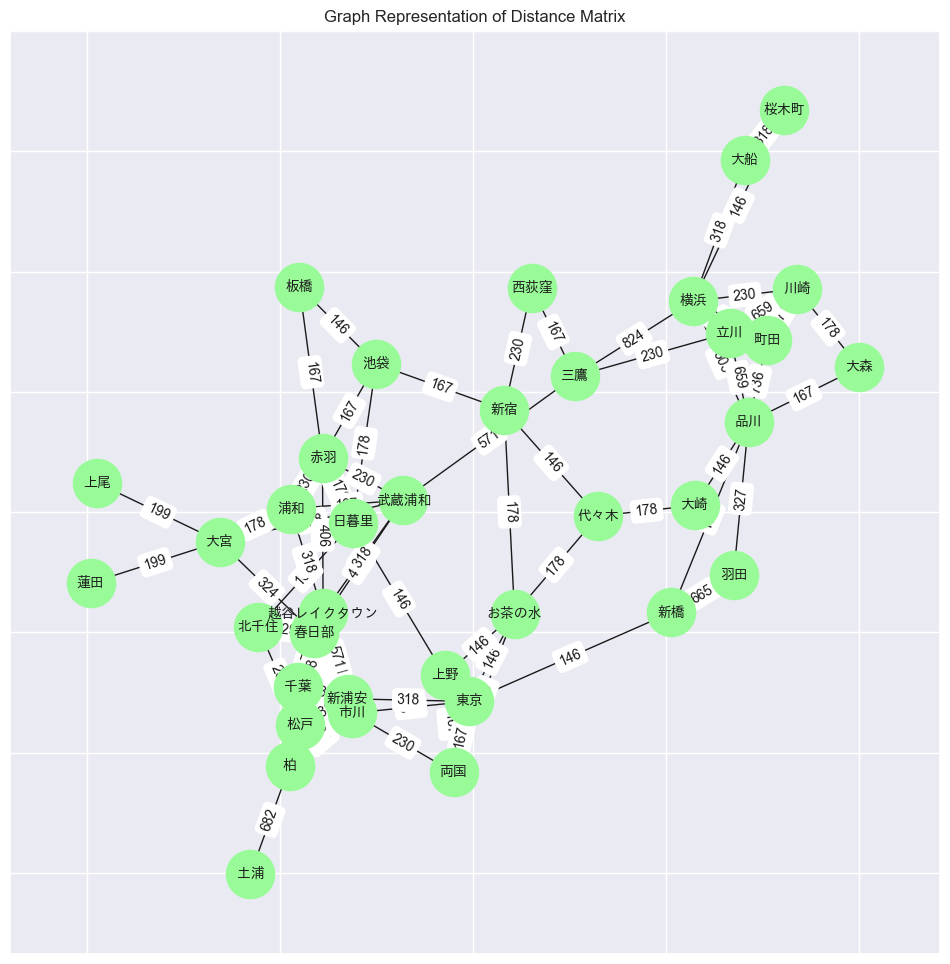

In [9]:
def draw_graph(graph):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(
        graph, pos, node_size=1200,
        node_color="#98fb98",
        ax=ax
    )
    
    edges = nx.draw_networkx_edges(graph, pos, edgelist=graph.edges(), width=1, ax=ax)
    edge_labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(
        graph, pos, edge_labels=edge_labels, ax=ax
    )

    nx.draw_networkx_labels(graph, pos, font_size=10, ax=ax, font_family='IPAexGothic')

    ax.set_title("Graph Representation of Distance Matrix")
    return fig

fig = draw_graph(G)

## 距離行列を作る

- フロイド-ワーシャル法によって、隣接してないノードのコストを計算

In [10]:
def distance_matrix_fw(graph):
    distance_matrix = nx.floyd_warshall_numpy(graph)
    return distance_matrix

エッジのつながっていない駅間のコストを無限大に設定する距離行列

In [11]:
def distance_matrix_inf(graph):
    distance_matrix = nx.to_numpy_array(graph, weight='weight')
    distance_matrix = np.array(distance_matrix)
    distance_matrix[distance_matrix == 0] = np.inf
    # 対角要素は 0 のままにする
    np.fill_diagonal(distance_matrix, 0)
    
    return distance_matrix

In [12]:
distance_matrix = distance_matrix_fw(G)
# distance_matrix = distance_matrix_inf(G)

all_weights = distance_matrix

print(all_weights.shape)
print(all_weights)

(37, 37)
[[   0.  888. 1062. ... 1171.  721.  407.]
 [ 888.    0.  575. ...  408.  470.  876.]
 [1062.  575.    0. ...  167.  731.  889.]
 ...
 [1171.  408.  167. ...    0.  564.  970.]
 [ 721.  470.  731. ...  564.    0.  406.]
 [ 407.  876.  889. ...  970.  406.    0.]]


In [13]:
pd.DataFrame(all_weights, index=uniq_stations, columns=uniq_stations)

,春日部,お茶の水,三鷹,上尾,上野,両国,代々木,北千住,千葉,品川,...,武蔵浦和,池袋,浦和,町田,立川,羽田,蓮田,西荻窪,赤羽,越谷レイクタウン
春日部,0.0,888.0,1062.0,523.0,742.0,909.0,1066.0,429.0,1071.0,1222.0,...,491.0,774.0,502.0,1775.0,1292.0,1549.0,523.0,1171.0,721.0,407.0
お茶の水,888.0,0.0,575.0,1077.0,146.0,146.0,178.0,459.0,782.0,459.0,...,700.0,345.0,700.0,1168.0,805.0,786.0,1077.0,408.0,470.0,876.0
三鷹,1062.0,575.0,0.0,948.0,721.0,721.0,543.0,909.0,1357.0,867.0,...,571.0,564.0,738.0,713.0,230.0,1194.0,948.0,167.0,731.0,889.0
上尾,523.0,1077.0,948.0,0.0,931.0,1098.0,1087.0,952.0,1431.0,1411.0,...,377.0,774.0,377.0,1661.0,1178.0,1738.0,398.0,1115.0,607.0,695.0
上野,742.0,146.0,721.0,931.0,0.0,167.0,324.0,313.0,803.0,480.0,...,554.0,324.0,554.0,1189.0,951.0,807.0,931.0,554.0,324.0,730.0
両国,909.0,146.0,721.0,1098.0,167.0,0.0,324.0,480.0,636.0,480.0,...,721.0,491.0,721.0,1189.0,951.0,807.0,1098.0,554.0,491.0,801.0
代々木,1066.0,178.0,543.0,1087.0,324.0,324.0,0.0,637.0,960.0,324.0,...,710.0,313.0,710.0,1033.0,773.0,651.0,1087.0,376.0,480.0,886.0
北千住,429.0,459.0,909.0,952.0,313.0,480.0,637.0,0.0,732.0,793.0,...,575.0,345.0,575.0,1502.0,1139.0,1120.0,952.0,742.0,345.0,548.0
千葉,1071.0,782.0,1357.0,1431.0,803.0,636.0,960.0,732.0,0.0,1037.0,...,1054.0,1077.0,1054.0,1746.0,1587.0,1364.0,1431.0,1190.0,1077.0,736.0
品川,1222.0,459.0,867.0,1411.0,480.0,480.0,324.0,793.0,1037.0,0.0,...,1034.0,637.0,1034.0,709.0,659.0,327.0,1411.0,700.0,804.0,1202.0


すでに通過した駅を除外する

In [14]:
stamped_stations = [
    "桜木町", "川崎", "浦和", "北千住", "大宮", "大船", "横浜",
    "日暮里", "上野", "赤羽", "越谷レイクタウン", "上尾", "蓮田", "武蔵浦和", "土浦", "松戸", "柏",
    "お茶の水", "三鷹", "両国", "代々木", "品川", "大崎", "大森", "新宿", "板橋", "池袋", "町田", "立川", "西荻窪", "新橋",
    # "羽田", "東京"
]
# stamped_stations = []
print(f"すでに通った駅の数: {len(stamped_stations)}")

すでに通った駅の数: 31


In [15]:
target_stations = np.array(uniq_stations).copy()
target_weights = all_weights.copy()
for ss in stamped_stations:
    station_index = np.where(target_stations == ss)[0]
    print(ss, station_index)
    target_stations = target_stations[target_stations != ss]
    target_weights = np.delete(target_weights, station_index, axis=0)
    target_weights = np.delete(target_weights, station_index, axis=1)
    # print(target_stations)
    # print(target_weights.shape)
    # break
print(f"対象となる駅 : {target_stations}")
print(f"対象となる距離行列 : {target_weights.shape}")

桜木町 [25]
川崎 [15]
浦和 [27]
北千住 [7]
大宮 [10]
大船 [12]
横浜 [21]
日暮里 [16]
上野 [4]
赤羽 [26]
越谷レイクタウン [26]
上尾 [3]
蓮田 [23]
武蔵浦和 [18]
土浦 [7]
松戸 [14]
柏 [15]
お茶の水 [1]
三鷹 [1]
両国 [1]
代々木 [1]
品川 [2]
大崎 [2]
大森 [2]
新宿 [3]
板橋 [6]
池袋 [6]
町田 [6]
立川 [6]
西荻窪 [7]
新橋 [3]
対象となる駅 : ['春日部' '千葉' '市川' '新浦安' '東京' '羽田']
対象となる距離行列 : (6, 6)


## データセット

In [16]:
data = {}
data['distance_matrix'] = target_weights
data['num_vehicles'] = 1
data['depot'] = 0

# 最短経路探索

In [17]:
manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
)
routing = pywrapcp.RoutingModel(manager)

In [18]:
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data["distance_matrix"][from_node][to_node]

In [19]:
transit_callback_index = routing.RegisterTransitCallback(distance_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [20]:
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)

In [21]:
solution = routing.SolveWithParameters(search_parameters)

In [22]:
def print_solution(manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()} miles")
    index = routing.Start(0)
    plan_output = "Route for vehicle 0:\n"
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += f" {target_stations[manager.IndexToNode(index)]} ->"
        # plan_output += f" {uniq_stations[manager.IndexToNode(index)]} ->"
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
    plan_output += f" {target_stations[manager.IndexToNode(index)]}\n"
    # plan_output += f" {uniq_stations[manager.IndexToNode(index)]}\n"
    print(plan_output)
    plan_output += f"Route distance: {route_distance}miles\n"

In [23]:
print_solution(manager, routing, solution)

Objective: 0 miles
Route for vehicle 0:
 春日部 -> 羽田 -> 東京 -> 新浦安 -> 市川 -> 千葉 -> 春日部



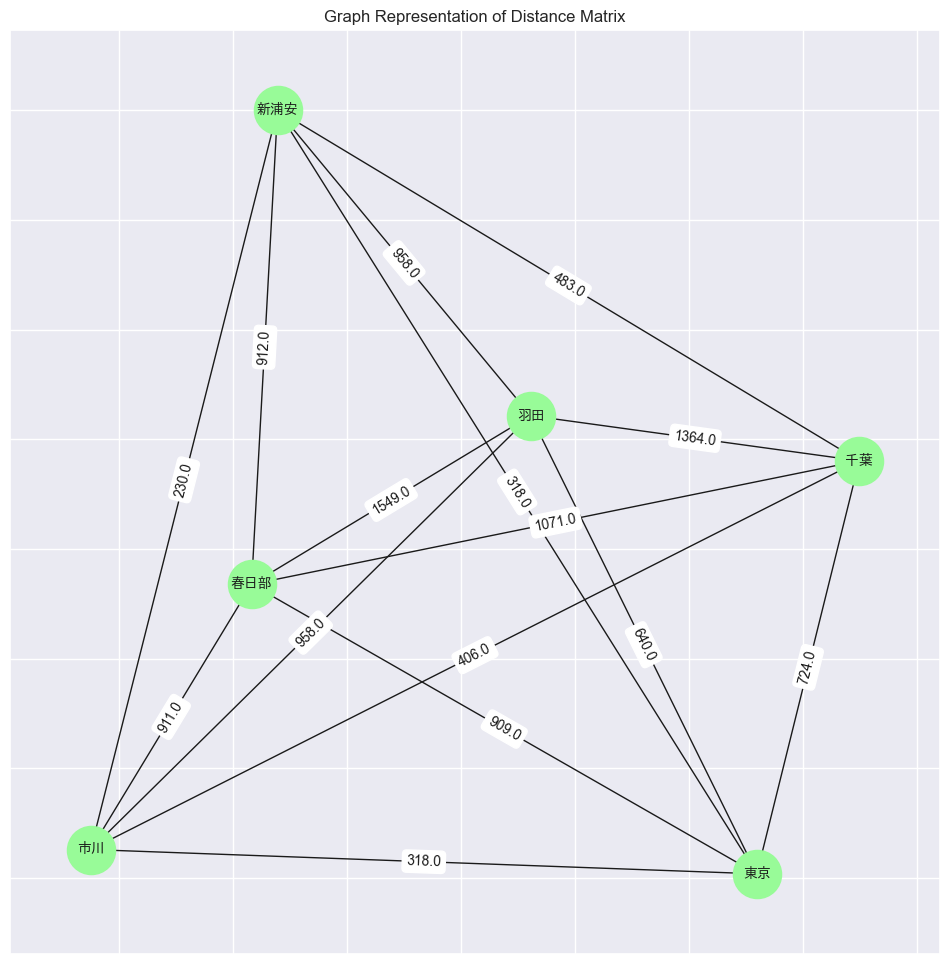

In [24]:
tG = nx.Graph()
n = len(target_stations)
for i in range(n):
    tG.add_node(target_stations[i])
    for j in range(i + 1, n):
        # 無限大でない場合にエッジを追加
        if target_weights[i, j] != np.inf:
            tG.add_edge(target_stations[i], target_stations[j], weight=target_weights[i, j])
fig = draw_graph(tG)

In [25]:
target_stations

array(['春日部', '千葉', '市川', '新浦安', '東京', '羽田'], dtype='<U8')

In [26]:
target_weights

array([[   0., 1071.,  911.,  912.,  909., 1549.],
       [1071.,    0.,  406.,  483.,  724., 1364.],
       [ 911.,  406.,    0.,  230.,  318.,  958.],
       [ 912.,  483.,  230.,    0.,  318.,  958.],
       [ 909.,  724.,  318.,  318.,    0.,  640.],
       [1549., 1364.,  958.,  958.,  640.,    0.]])